In [1]:
import numpy as np
import torch
from torch import nn
import csv
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from utils import get_rho_from_u, plot_3d, get_rho_network_from_u

In [2]:
class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        x = self.model(torch.from_numpy(x).float())
        x = torch.tanh(x)
        x = x / 2
        return x

In [3]:
def get_rho_from_u(u, d):
    n_cell = u.shape[0]
    T_terminal = int(u.shape[1] / u.shape[0])
    rho = np.zeros((n_cell, n_cell * T_terminal), dtype=np.float64)
    for t in range(n_cell * T_terminal):
        for i in range(n_cell):
            if t == 0:
                rho[i, t] = d[i]
            else:
                if i == 0:
                    rho[i, t] = rho[i, t - 1] + rho[-1, t - 1] * u[-1, t - 1] - rho[i, t - 1] * u[i, t - 1]
                else:
                    rho[i, t] = rho[i][t - 1] + rho[i - 1, t - 1] * u[i - 1, t - 1] - rho[i, t - 1] * u[i, t - 1]

    return rho

In [4]:
def train_critic_fake(n_cell, T_terminal, V_array):
    T = n_cell * T_terminal
    truths = []
    keys = []

    liu = Critic(2)
    liu_optimizer = torch.optim.Adam(liu.parameters(), lr=1e-3)

    for i in range(n_cell + 1):
        for t in range(T + 1):
            truths.append(V_array[i, t])
            keys.append(np.array([i, t]) / n_cell)

    for _ in range(1000):
        truths = torch.tensor(truths, requires_grad=True)
        preds = torch.reshape(liu(np.array(keys)), (1, len(truths)))
        loss = (truths - preds).abs().mean()
        # print(loss)
        liu_optimizer.zero_grad()
        loss.backward()
        liu_optimizer.step()

    pred_V = np.zeros((n_cell + 1, T + 1))
    for i in range(n_cell + 1):
        for t in range(T + 1):
            pred_V[i, t] = liu(np.array([i, t]) / n_cell)

    return liu

In [5]:
class RhoNetwork(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        return self.model(torch.from_numpy(x).float())


In [6]:
def train_rho_network_one_step(n_cell, T_terminal, rho, rho_network, rho_optimizer):
    truths, keys = list(), list()
    for i in range(len(rho)):
        for j in range(len(rho[0])):
            truths.append(rho[i, j])
            keys.append(np.array([i, j]) / n_cell)

    for _ in range(3000):
        truths = torch.tensor(truths, requires_grad=True)
        preds = torch.reshape(rho_network(np.array(keys)), (1, len(truths)))
        loss = (truths - preds).abs().mean()
        rho_optimizer.zero_grad()
        loss.backward()
        rho_optimizer.step()

    return rho_network

In [7]:
n_cell = 8
T_terminal = 1
data = pd.read_csv('data_rho_8.csv')
rho = np.array(data.iloc[:, 1:len(data.iloc[0, :])])
d = rho[:, 0]

In [8]:
delta_T = 1 / n_cell
T = int(T_terminal / delta_T)
u_hist = [0.5 * np.ones((n_cell, T))]
rho_hist = [get_rho_from_u(u_hist[0], d)]
# u_diff_hist, rho_diff_hist = list(), list()

u = 0.5 * np.ones((n_cell, T))
V = np.zeros((n_cell + 1, T + 1), dtype=np.float64)
rho = get_rho_from_u(u, d)

rho_network = RhoNetwork(2)
rho_optimizer = torch.optim.Adam(rho_network.parameters(), lr=1e-3)
rho_network = train_rho_network_one_step(n_cell, T_terminal, rho, rho_network, rho_optimizer)

fake_critic = Critic(2) #train_critic_fake(n_cell, T_terminal, np.zeros((n_cell + 1, T + 1)))
critic = Critic(2)
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=1e-3)

<ipython-input-6-740cff3be2e7>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  truths = torch.tensor(truths, requires_grad=True)


<ipython-input-6-740cff3be2e7>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  truths = torch.tensor(truths, requires_grad=True)
/Users/ninolau/Documents/GitHub/speed_control/utils.py:72: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')
/Users/ninolau/Documents/GitHub/speed_control/utils.py:72: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The g

Traceback (most recent call last):
  File "/Users/ninolau/anaconda3/envs/deeplearning/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-8d4101b810f1>", line 29, in <module>
    critic_optimizer.zero_grad()
  File "/Users/ninolau/anaconda3/envs/deeplearning/lib/python3.8/site-packages/torch/optim/optimizer.py", line 237, in zero_grad
    with torch.autograd.profiler.record_function(self._zero_grad_profile_name):
  File "/Users/ninolau/anaconda3/envs/deeplearning/lib/python3.8/site-packages/torch/autograd/profiler.py", line 443, in __init__
    self.handle: torch.Tensor = torch.zeros(1)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/ninolau/anaconda3/envs/deeplearning/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2061, in showtraceback
    stb = value._render_trac

TypeError: object of type 'NoneType' has no len()

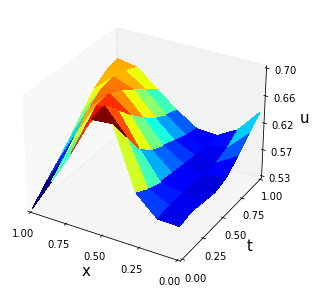

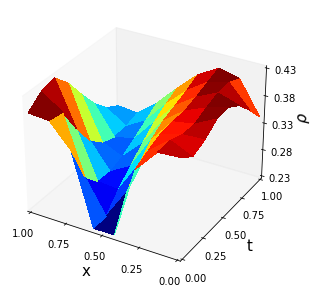

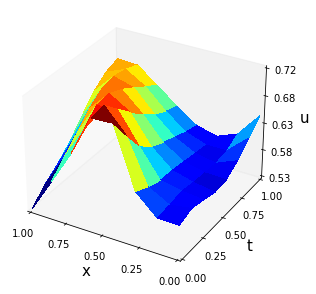

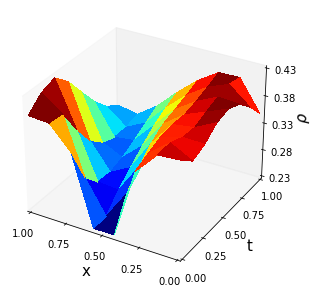

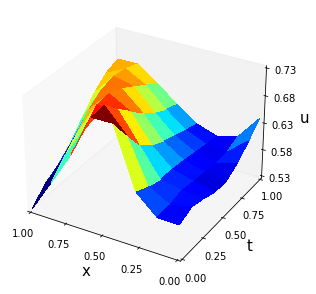

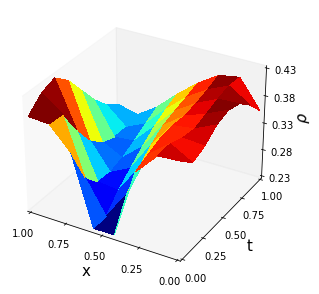

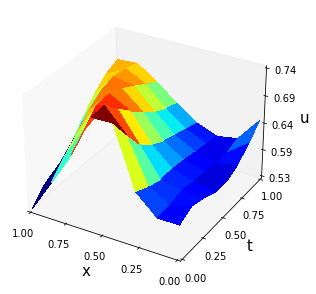

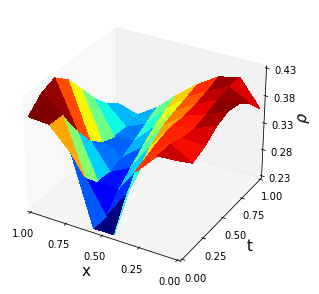

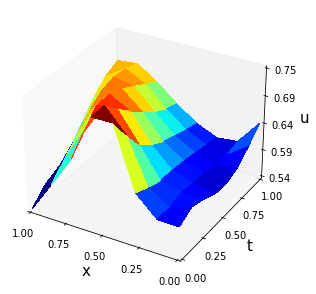

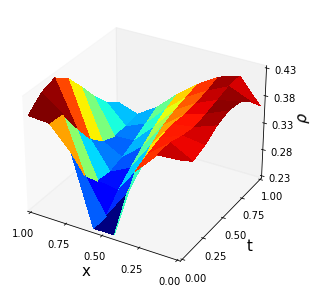

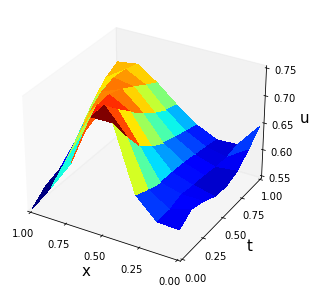

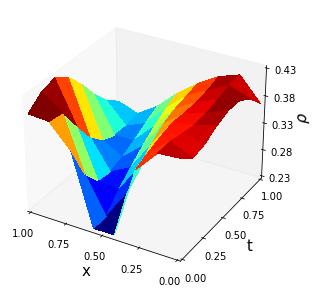

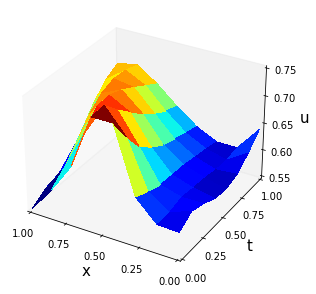

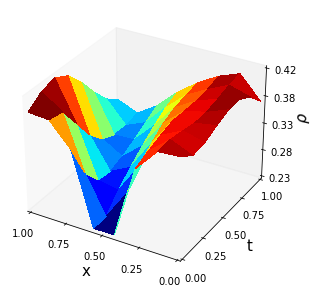

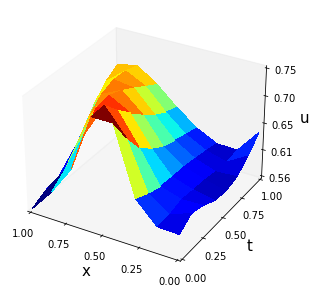

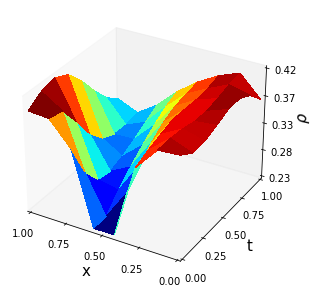

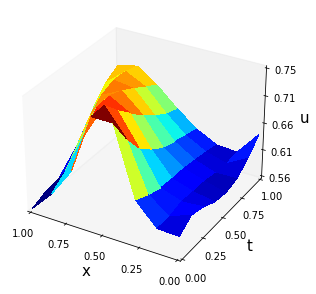

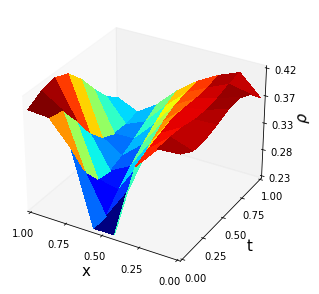

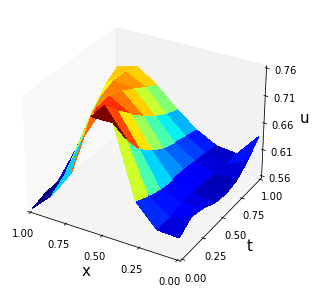

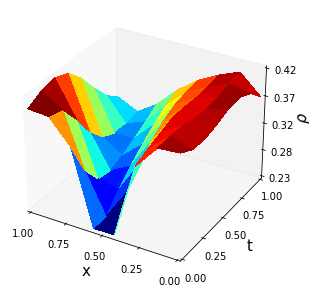

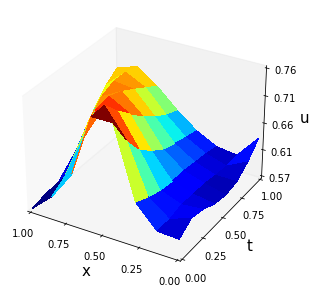

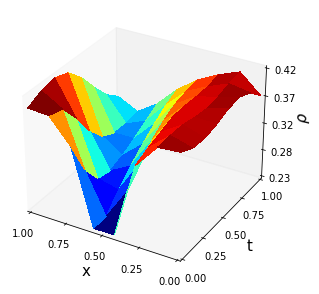

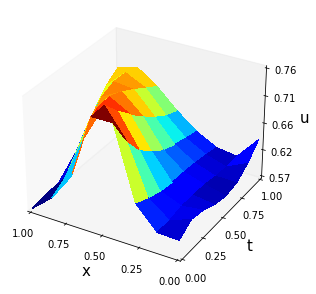

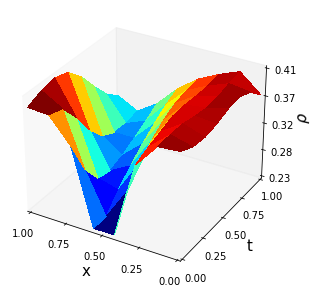

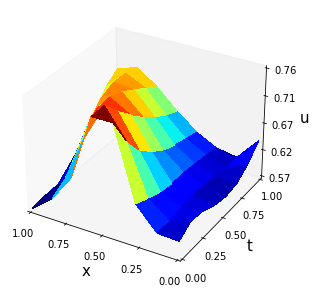

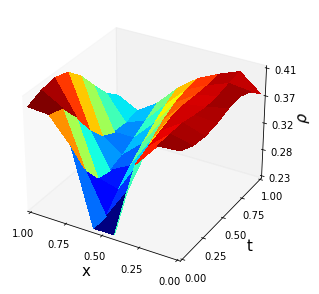

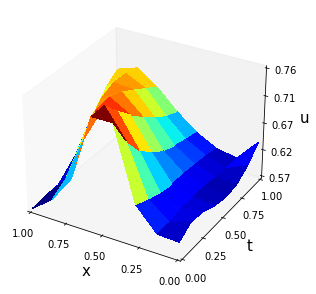

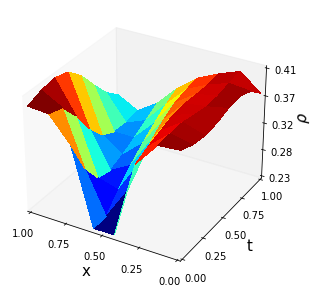

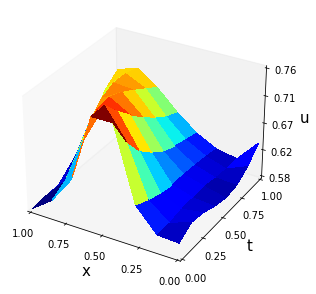

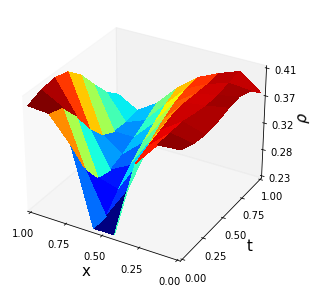

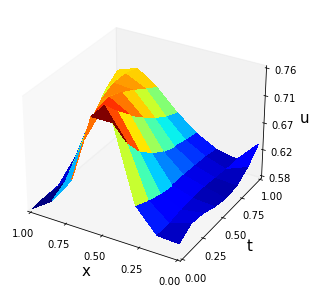

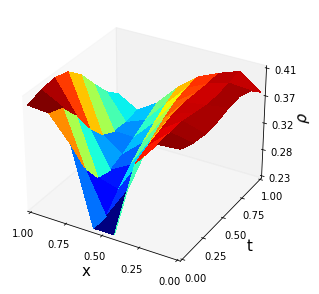

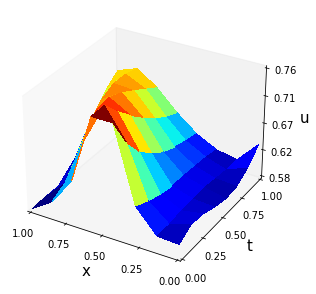

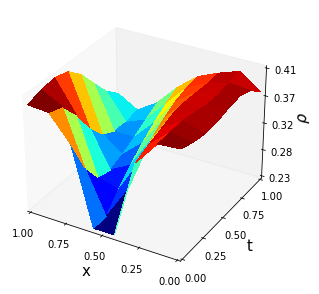

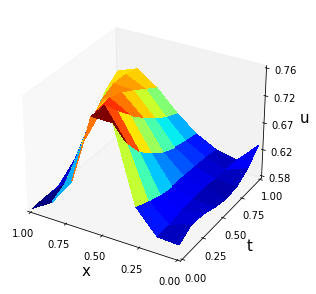

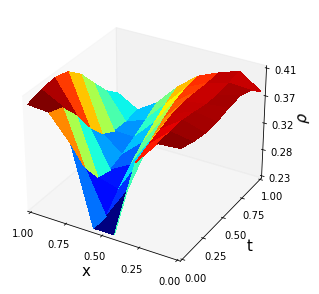

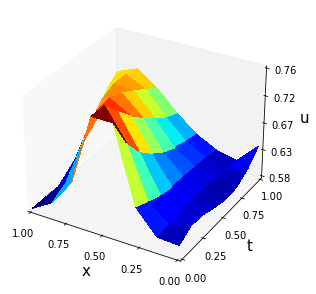

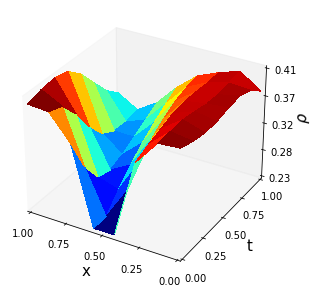

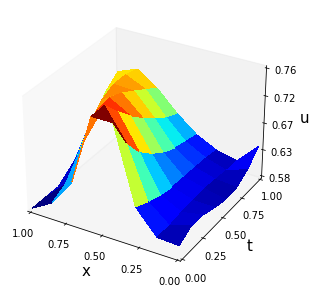

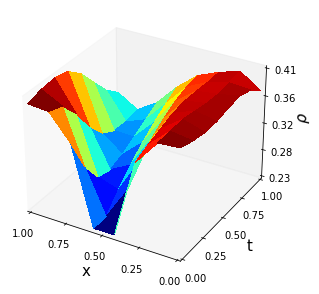

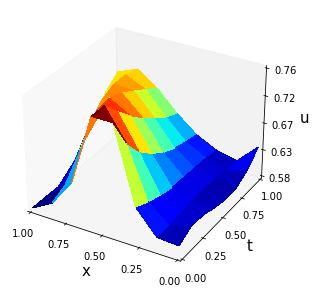

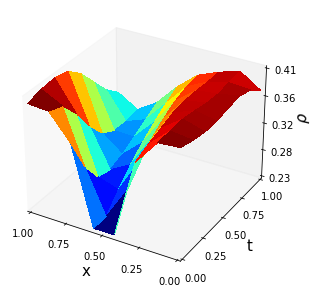

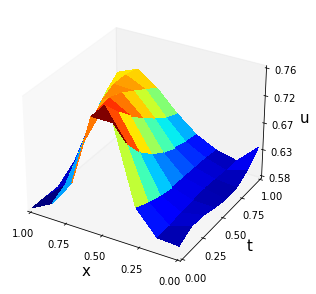

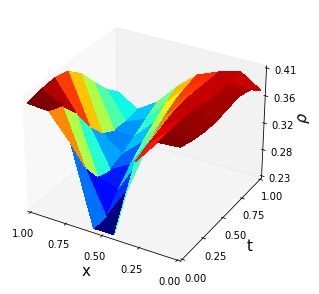

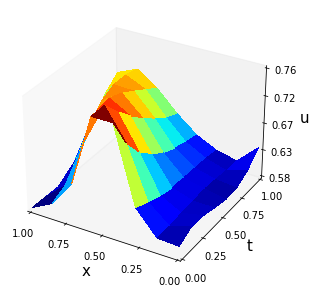

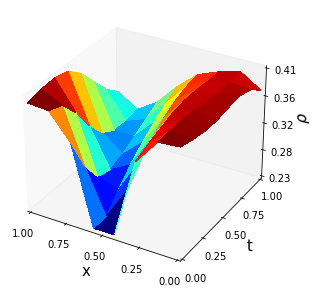

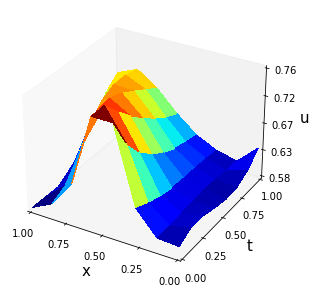

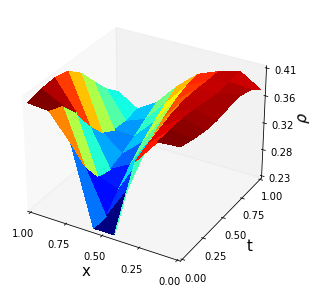

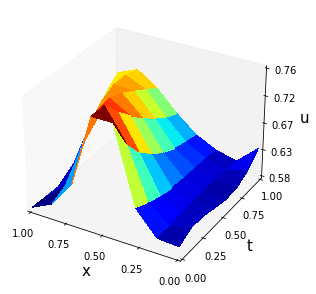

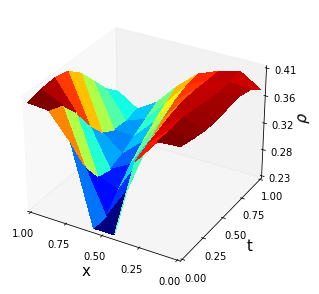

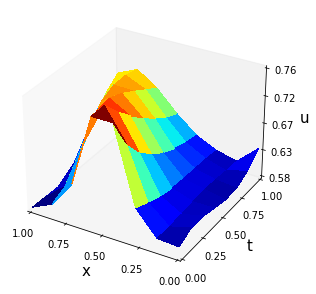

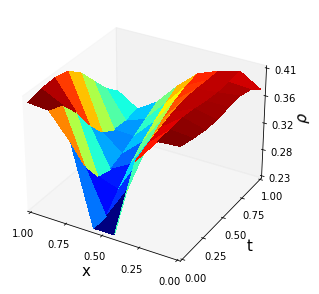

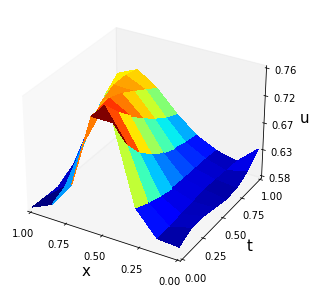

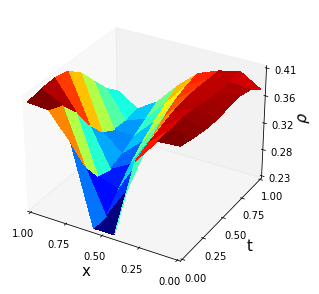

In [9]:
for it in range(100):
    states = list()
    truths = list()
    u = np.ones((n_cell, T))
    for i in range(n_cell + 1):
        for t in range(T + 1):
            states.append(np.array([i, t]) / n_cell)
            if t == T:
                truths.append(0)
            else:
                if i == n_cell:
                    # rho_i_t = rho[0,t]
                    rho_i_t = float(rho_network.forward(np.array([0, t]) / n_cell))
                    speed = 1- rho_i_t
                    truths.append(delta_T * 0.5 * (1 - speed - rho_i_t) ** 2 + fake_critic(
                        np.array([speed, t + 1]) / n_cell))
                else:
                    # rho_i_t = rho[i,t]
                    rho_i_t = float(rho_network.forward(np.array([i, t]) / n_cell))
                    speed = 1- rho_i_t
                    u[i, t] = speed
                    truths.append(delta_T * 0.5 * (1 - speed - rho_i_t) ** 2 + fake_critic(
                        np.array([speed, t + 1]) / n_cell))
                    
    truths = torch.tensor(truths, requires_grad=True)
    for c_it in range(3000):
        preds = torch.reshape(critic(np.array(states)), (1, len(truths)))
        critic_loss = (truths - preds).abs().mean()
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()

    fake_critic = critic

    u_hist.append(u)
    u = np.array(u_hist).mean(axis=0)
    rho = get_rho_from_u(u, d)
    rho_hist.append(rho)
    # u_diff_hist.append(np.mean(abs(u_hist[-1] - u_hist[-2])))
    # rho_diff_hist.append(np.mean(abs(rho_hist[-1] - rho_hist[-2])))
    rho_network = train_rho_network_one_step(n_cell, T_terminal, rho, rho_network, rho_optimizer)
    # rho_network = get_rho_network_from_u(n_cell, T_terminal, u, d, rho_network, rho_optimizer, n_iterations=3000)
    if it % 2 == 0 and it != 0:
        plot_3d(n_cell, T_terminal, u, "u", f"./fig/u/{it}.pdf")
        plot_3d(n_cell, T_terminal, rho, r"$\rho$", f"./fig/rho/{it}.pdf")

# u_diff_df = pd.DataFrame(u_diff_hist)
# u_diff_df.to_csv(f"./diff/u-sep.csv")
# rho_diff_df = pd.DataFrame(rho_diff_hist)
# rho_diff_df.to_csv(f"./diff/rho-sep.csv")

In [ ]:
plot_3d(8,1,rho,r"$\rho$",None)

In [ ]:
plot_3d(8,1,u,"u",None)

## Smooth Plot

In [ ]:
class Actor(nn.Module):
    def __init__(self, state_dim):
        super(Actor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        x = self.model(torch.from_numpy(x).float())
        x = torch.tanh(x)
        x = (x + 1) / 2
        return x

In [ ]:
actor = Actor(2)
actor_optimizer = torch.optim.Adam(actor.parameters(), lr=1e-3)
truths = []
keys = []
for i in range(8):
    for j in range(8):
        truths.append(u[i, j])
        keys.append(np.array([i, j]) / 8)

truths = torch.tensor(truths, requires_grad=True)
for _ in range(5000):
    preds = torch.reshape(actor(np.array(keys)), (1, len(truths)))
    loss = (truths - preds).abs().mean()
    actor_optimizer.zero_grad()
    loss.backward()
    actor_optimizer.step()

rho_network = train_rho_network_one_step(n_cell, T_terminal, rho, rho_network, rho_optimizer)

In [ ]:
u_plot = np.zeros((n_cell * 4, T * 4))
rho_plot = np.zeros((n_cell * 4, T * 4))
for i in range(n_cell * 4):
    for t in range(T * 4):
        u_plot[i, t] = actor(np.array([i, t]) / n_cell / 4)
        rho_plot[i, t] = rho_network(np.array([i, t]) / n_cell / 4)

plot_3d(n_cell * 4, T_terminal, u_plot, r"u", None)
plot_3d(n_cell * 4, T_terminal, rho_plot, r"$\rho$", None)